In [180]:
from sklearn.model_selection import cross_val_score
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
from collections import Counter
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeRegressor
import time
from sklearn.preprocessing import LabelEncoder
from typing import List, Union, Type, Any
import gc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, confusion_matrix, accuracy_score, f1_score, r2_score,  precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Создадим класс дерева решений

In [172]:
class DecisionTree:
    
    """Класс дерева решений
    
    Параметры:
    self.max_depth (int): Максимальная глубина дерева.
    self.min_samples_split (int): Минимальное количество объектов для разбиения узла.
    self.criterion (str): Критерий разбиения ('gini' для классификации, 'mse' для регрессии).
    self.tree (dict | None): Структура дерева, инициализируется после обучения.
    
    Методы:
    fit(self, X: pd.DataFrame, y: pd.DataFrame): - обучение модели.
    _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int): - Рекурсивное построение дерева 
    _best_split(self, X: pd.DataFrame, y: pd.DataFrame): Поиск наилучшего разбиения 
    _split_score(self, left_y: : pd.DataFrame, right_y: : pd.DataFrame): Оценка качества разбиения (Gini для классификации, MSE для регрессии): 
    _gini(self, y): Расчет критерия Джини.
    _mse(self, y): Расчет среднеквадратичной ошибки 
    _is_pure(self, y): Проверка, содержит ли y только один уникальный класс
    _create_leaf(self, y):  Создание листового узла
    predict(self, X): Метод предсказания(Применение дерева к данным)
    _traverse_tree(self, x, node): метод - выполняет рекурсивный обход дерева решений для предсказания значения на основе входных данных
    """
    
    def __init__(self, max_depth: int =5, min_samples_split: int =2, criterion: str='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion  
        self.tree = None
    
    def fit(self, X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray) -> None:
        
        """
        Обучение модели. X - обучающие данные, y - целевые значения.
        """
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        
        self.tree = self._build_tree(X, y, 0)

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> dict | float:
        """
        Рекурсивное построение дерева.
        Параметры:
            X - обучающие данные,
            y - целевые значения,
            depth - текущая глубина.
        Возвращает узел дерева (словарь) или лист (число).
        """
    
        if depth >= self.max_depth or len(y) < self.min_samples_split or self._is_pure(y):
            return self._create_leaf(y)
        
        feature, threshold = self._best_split(X, y)
        
        if feature == -1:  # Проверяем, что разбиение найдено
            return self._create_leaf(y)
    
        left_idx = X[:, feature] < threshold
        right_idx = ~left_idx
    
        return {
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(X[left_idx], y[left_idx], depth + 1),
            'right': self._build_tree(X[right_idx], y[right_idx], depth + 1)
        }


    def _best_split(self, X: np.ndarray, y: np.ndarray) -> tuple[int | None, float | None]:

        """
        Поиск наилучшего разбиения.
        Параметры:
            X - обучающие данные,
            y - целевые значения,
        Возвращает индекс признака и порог или (None, None), если разбиение невозможно.
        """
        
        best_feature, best_threshold = None, None
        best_score = np.inf  
    
        for feature in range(X.shape[1]):  
            thresholds = np.unique(X[:, feature])  
            for threshold in thresholds:
                left_mask = X[:, feature] < threshold
                right_mask = ~left_mask  
    
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue  
    
                score = self._split_score(y[left_mask], y[right_mask])  
    
                if score < best_score:  
                    best_feature, best_threshold, best_score = feature, threshold, score
    
        if best_feature is None or best_threshold is None:  # Защита от ошибки
            return -1, np.nan  # Вместо None вернем фиктивное значение
    
        return best_feature, best_threshold

    def _split_score(self, left_y: np.ndarray, right_y: np.ndarray) -> float:

        """
        Оценка качества разбиения (Gini для классификации, MSE для регрессии).
        Параметры:
            left_y - целевые значения слева,
            right_y - целевые значения справа,
        Возвращает результат оценки.
        """
       
        if self.criterion == 'gini':
            return self._gini(left_y) * len(left_y) + self._gini(right_y) * len(right_y)
        elif self.criterion == 'mse':
            return self._mse(left_y) * len(left_y) + self._mse(right_y) * len(right_y)

    def _gini(self, y: np.ndarray) -> float:

        """
        Расчет критерия Джини.
        Параметры:
            y - целевые значения,
        Возвращает критерий Джини.
        """
        
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return 1 - np.sum(probs ** 2)

    def _mse(self, y: np.ndarray) -> float:

        """
        Расчет среднеквадратичной ошибки..
        Параметры:
            y - целевые значения,
        Возвращает MSE.
        """
       
        return np.mean((y - np.mean(y)) ** 2)
    
    def _is_pure(self, y: np.ndarray) -> bool:

        """
        Проверка, содержит ли y только один уникальный класс.
        Параметры:
            y - целевые значения,
        Возвращает да или нет.
        """
        
        return len(np.unique(y)) == 1
    
    def _create_leaf(self, y: np.ndarray) -> float:

        """
        Создание листового узла.
        Параметры:
            y - целевые значения,
        Возвращает среднее значение
        """
       
        if self.criterion == 'mse':
            return np.mean(y)  # Для регрессии - среднее значение
        elif self.criterion == 'gini':
            return np.bincount(y.astype(int)).argmax()  # Для классификации - наиболее частый класс
    
    def predict(self, X: pd.DataFrame | np.ndarray) -> np.ndarray:

        """
        Предсказание классов или значений для входных данных X.
        Параметры:
            X - проверочные данные,
        Возвращает массив предсказаний
        """
        # print(X.shape)
        X = np.atleast_2d(X)

        return np.array([self._traverse_tree(x.flatten(), self.tree) for x in X])

    def _traverse_tree(self, x: np.ndarray, node: dict | float) -> float:

        """
        Выполняет рекурсивный обход дерева решений для предсказания значения.
        Параметры:
            X - проверочные данные,
        Возвращает предсказание модели
        """
        
        if not isinstance(node, dict):  # Если узел — лист, вернуть значение
            return node
        
        # Преобразуем x в numpy-массив и проверяем форму
        x = np.asarray(x).flatten()  # Делаем его одномерным вектором
        
        # print(f"Текущий узел: {node}, размер x: {x.shape}")
        if x.shape[0] <= node['feature']:  # Проверяем, чтобы индекс существовал
            raise IndexError(f"Ошибка: feature index {node['feature']} выходит за границы (размер x: {x.shape[0]})")
        
        if x[node['feature']] < node['threshold']:
            return self._traverse_tree(x, node['left'])
        else:
            return self._traverse_tree(x, node['right'])


# Создадим класс RandomForest

In [184]:
def fit_tree(tree, X, y):
    """
    Функция для обучения одного дерева (нужна для joblib)
    Параметры:
            tree : Any Базовое дерево решений.
            X - обучающие данные,
            y - целевые значения,
    Возвращает: обученное дерево
    """
    X_sample, y_sample = RandomForest._bootstrap_sample_static(X, y)
    tree.fit(X_sample, y_sample)
    return tree


class RandomForest:
    """Класс случайного леса (RandomForest).
    
    Параметры:
    ----------
    base_tree : Type[Any]             Класс базового дерева решений.
    n_trees : int, default=10         Количество деревьев в лесу.
    max_depth : int, default=5        Максимальная глубина каждого дерева.
    min_samples_split : int, default=2        Минимальное количество объектов в узле перед разделением.
    max_features : default=None        Максимальное количество признаков, используемых при разделении (по умолчанию все).
    random_state : , default=None        Начальное значение для генератора случайных чисел (для воспроизводимости).
    forest_type : str, default='regression'        Тип задачи: 'regression' для регрессии, 'classification' для классификации.
    trees : List[Any]        Список обученных деревьев решений.

    Методы:
    -------
    fit(X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]) -> None
        Обучает случайный лес на данных X и y.
    predict(X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray
        Выполняет предсказание на новых данных X.
    _bootstrap_sample_static(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]
        Создаёт бутстрэп-выборку (сэмплирование с возвращением).
    """

    def __init__(
        self,
        base_tree: Type[Any],
        n_trees: int = 10,
        max_depth: int = 5,
        min_samples_split: int = 2,
        max_features: int = None,
        random_state: int = None,
        forest_type: str = "regression"
    ) -> None:
        self.n_trees = n_trees
        self.max_features = max_features
        self.random_state = random_state
        self.forest_type = forest_type
        self.trees: List[Any] = [
            base_tree(max_depth=max_depth, min_samples_split=min_samples_split,
                     criterion="mse" if forest_type == "regression" else "gini")
            for _ in range(self.n_trees)
        ]

    @staticmethod
    def _bootstrap_sample_static(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Создаёт бутстрэп-выборку из X и y.
        Параметры:
            X - обучающие данные,
            y - целевые значения,
        Возвращает выборку
        """
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[idxs], y[idxs]

    def fit(self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]) -> None:
        
        """
        Обучает случайный лес(выборку)
        Параметры:
            X - обучающие данные,
            y - целевые значения,
        Возвращает выборку
        """
        
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()

        assert isinstance(X, np.ndarray), f"Ошибка: X имеет тип {type(X)}"
        assert isinstance(y, np.ndarray), f"Ошибка: y имеет тип {type(y)}"

        np.random.seed(self.random_state)  # Фиксируем сид для воспроизводимости

        def fit_tree(tree, X, y):
            X_sample, y_sample = self._bootstrap_sample_static(X, y)
            tree.fit(X_sample, y_sample)
            return tree

        self.trees = Parallel(n_jobs=-1)(delayed(fit_tree)(tree, X, y) for tree in self.trees)

    def predict(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        """
        Выполняет предсказание, усредняя результаты деревьев (для регрессии) или голосованием (для классификации).
        Параметры:
            X - обучающие данные,
            y - целевые значения,
        Возвращает матрицу предсказаний
        """
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()

        predictions = np.array(Parallel(n_jobs=-1)(delayed(tree.predict)(X) for tree in self.trees))  # (N_trees, N_samples)

        if self.forest_type == "regression":
            return np.mean(predictions, axis=0)
        elif self.forest_type == "classification":
            return np.array([Counter(predictions[:, i]).most_common(1)[0][0] for i in range(X.shape[0])])
        else:
            raise ValueError("Некорректное значение forest_type. Используйте 'regression' или 'classification'.")

    def get_params(self, deep=True):
        """
        Возвращает параметры модели, как это делает sklearn.
        """
        return {"n_trees": self.n_trees, "max_depth": self.max_depth}

    def set_params(self, **params):
        """
        Устанавливает параметры модели, как это делает sklearn.
        """
        for param, value in params.items():
            setattr(self, param, value)
        return self


# Загрузим датасет по квартирам Бостона

In [15]:
boston_df = pd.read_csv('content/BostonHousing.csv')

In [16]:
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [35]:
X = boston_df.drop(columns=['medv'])
y = boston_df.medv

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Создаём Random Forest для регрессии
forest = RandomForest(
    base_tree=DecisionTree,  
    n_trees=10, 
    max_depth=5, 
    min_samples_split=2, 
    max_features=5, 
    random_state=42, 
    forest_type='regression'
)

# Обучаем
forest.fit(X_train, y_train)

# Предсказываем
y_pred = forest.predict(X_test.to_numpy())  # Преобразуем DataFrame в numpy

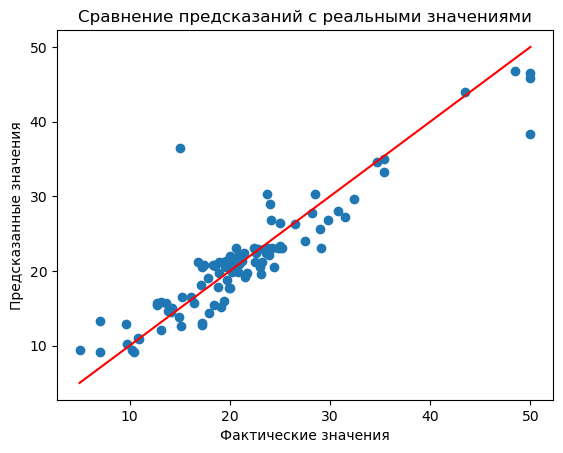

In [61]:
plt.scatter(y_test, y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Линия идеального предсказания
plt.show()

# Создадим фукнцию для xboost

In [161]:
def fit_boosting_tree(tree: Any, X: Union[np.ndarray, pd.DataFrame], residuals: Union[np.ndarray, pd.Series]) -> Any:
    """
    Обучает одно дерево на остатках ошибки (нужно для joblib).

    Параметры:
        tree : Any Базовое дерево решений.
        X : Union[np.ndarray, pd.DataFrame]        Обучающие данные.
        residuals : Union[np.ndarray, pd.Series]   Остатки ошибок модели.
    Возвращает:
        tree : Any  Обученное дерево.
    """
    
    if isinstance(residuals, pd.Series):
        residuals = residuals.to_numpy()

    if tree.criterion == 'gini':  # Если это классификация, приводим к int
        residuals = residuals.astype(int)

    tree.fit(X, residuals)
    return tree

class XGBoost:
    """
    Реализация градиентного бустинга деревьев решений (XGBoost).
    
    Параметры:
    base_tree : Type[Any]        Класс базового дерева решений.
    n_trees : int, default=10        Количество деревьев в ансамбле.
    max_depth : int, default=5        Максимальная глубина каждого дерева.
    min_samples_split : int, default=2        Минимальное количество объектов в узле перед разделением.
    learning_rate : float, default=0.1        Скорость обучения (вес каждого нового дерева).
    random_state : int, default=None        Начальное значение для генератора случайных чисел (для воспроизводимости).
    forest_type : str, default='regression'        Тип задачи: 'regression' для регрессии, 'classification' для классификации.
    trees : List[Any]        Список обученных деревьев решений.
    initial_prediction : float        Начальное предсказание (среднее значение целевой переменной для регрессии,
        либо наиболее частый класс для классификации).

    Методы:
    -------
    fit(X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]) -> None        Обучает модель на данных X и y.
    predict(X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray        Выполняет предсказание на новых данных X.
    """

    def __init__(
        self,
        base_tree: Type[Any],
        n_trees: int = 10,
        max_depth: int = 5,
        min_samples_split: int = 2,
        learning_rate: float = 0.1,
        random_state: int = None,
        forest_type: str = "regression"
    ) -> None:
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.forest_type = forest_type
        self.trees: List[Any] = []
        self.initial_prediction: float = None
        self.base_tree = base_tree  # Сохраняем базовую модель

    def fit(self, X: Union[np.ndarray, pd.DataFrame], y: Union[np.ndarray, pd.Series]) -> None:
        """
        Обучает деревья последовательно (градиентный бустинг).
    
        Параметры:
            tree : Any Базовое дерево решений.
            X : Union[np.ndarray, pd.DataFrame]        Обучающие данные.
            y: Union[np.ndarray, pd.Series]    Целевые обучющие данные

        """
        
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)  # Приводим X к DataFrame для удобства

        if self.forest_type == "regression":
            self.initial_prediction = np.mean(y)
        else:
            self.initial_prediction = Counter(y).most_common(1)[0][0]

        predictions = np.full_like(y, self.initial_prediction, dtype=np.float64)

        for _ in range(self.n_trees):
            residuals = y - predictions  # Остатки ошибки

            tree = self.base_tree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                criterion="mse" if self.forest_type == "regression" else "gini"
            )

            tree = fit_boosting_tree(tree, X, residuals)  # Обучаем дерево на остатках ошибки
            self.trees.append(tree)  # Добавляем в ансамбль

            predictions += self.learning_rate * tree.predict(X)  # Обновляем предсказания

    def predict(self, X: Union[np.ndarray, pd.DataFrame]) -> np.ndarray:
        
        """
        Выполняет предсказание, суммируя результаты деревьев.
    
        Параметры:
            tree : Any Базовое дерево решений.
            X : Union[np.ndarray, pd.DataFrame]        Валидирущие данные.
        Возвращает:
            np.ndarray  - матрицу предсказаний
        """
        
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()  # Приводим X к numpy

        predictions = np.full(X.shape[0], self.initial_prediction, dtype=np.float64)

        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)

        if self.forest_type == "classification":
            return np.round(predictions).astype(int)  # Приводим к целым числам для классификации
        return predictions

In [65]:
xgboost_model = XGBoost(
    base_tree=DecisionTree,  # Базовая модель — наше дерево решений
    n_trees=50,              # Количество деревьев
    learning_rate=0.1,       # Скорость обучения (вклад каждого дерева в итоговое предсказание)
    max_depth=5,             # Глубина деревьев
    forest_type='regression' # Режим работы: регрессия 
)
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_test)

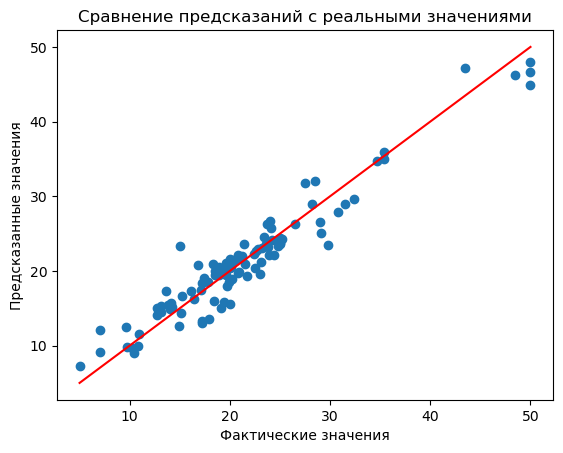

In [66]:
plt.scatter(y_test, y_pred_xgb)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Линия идеального предсказания
plt.show()

# Протестируем наши и коробочные модели на разных параметрах.

In [76]:
# Функция для обучения и оценки модели с измерением времени
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    """Обучает модель, делает предсказания, оценивает метрики и измеряет время."""
    start_time = time.time()  # Засекаем время
    model.fit(X_train, y_train)  # Обучение
    elapsed_time = time.time() - start_time  # Измеряем время
    
    y_pred = model.predict(X_test)  # Предсказание

    # Вычисляем метрики
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Возвращаем результаты в виде словаря
    return {
        "Модель": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "Время (сек)": elapsed_time
    }

# Гиперпараметры (общие для всех)
param_grid = {
    "n_trees": [10, 50, 100, 150, 200],  # Кол-во деревьев
    "max_depth": [2, 3, 5],  # Глубина деревьев
}

# Список моделей
models = [
    ("RandomForest (Custom)", RandomForest(base_tree=DecisionTree, n_trees=50, max_depth=5)),  
    ("XGBoost (Custom)", XGBoost(base_tree=DecisionTree, n_trees=50, max_depth=5, learning_rate=0.1)),
    ("DecisionTreeRegressor", DecisionTreeRegressor()),
    ("RandomForestRegressor", RandomForestRegressor(n_estimators=50, max_depth=5)),
    ("GradientBoostingRegressor", GradientBoostingRegressor(n_estimators=50, max_depth=5)),
]

# Храним результаты
results = []

# Прогоняем модели по всем параметрам
for model_name, model in models:
    for n_trees in param_grid["n_trees"]:
        for max_depth in param_grid["max_depth"]:
            # Настраиваем параметры для кастомных моделей
            if "Custom" in model_name:
                model.n_trees = n_trees
                model.max_depth = max_depth
            elif isinstance(model, (RandomForestRegressor, GradientBoostingRegressor)):
                model.set_params(n_estimators=n_trees, max_depth=max_depth)
            elif isinstance(model, DecisionTreeRegressor):
                model.set_params(max_depth=max_depth)

            # Оцениваем модель
            result = evaluate_model(model, f"{model_name} (trees={n_trees}, depth={max_depth})", 
                                    X_train, y_train, X_test, y_test)
            results.append(result)



In [80]:
# Преобразуем результаты в DataFrame
df_results = pd.DataFrame(results)

df_results_filtered = df_results[df_results["R2"] > 0].sort_values(by="R2", ascending=False)

# Отключаем перенос по ширине и увеличиваем лимит строк
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 100)

# Выводим таблицу
print(df_results_filtered)


                                            Модель       MAE      RMSE        R2  Время (сек)
68  GradientBoostingRegressor (trees=100, depth=5)  1.761931  2.258288  0.930457     0.231347
71  GradientBoostingRegressor (trees=150, depth=5)  1.785844  2.266868  0.929927     0.302972
65   GradientBoostingRegressor (trees=50, depth=5)  1.832495  2.335467  0.925622     0.093939
74  GradientBoostingRegressor (trees=200, depth=5)  1.812248  2.353779  0.924451     0.374801
70  GradientBoostingRegressor (trees=150, depth=3)  1.881361  2.450386  0.918122     0.195595
73  GradientBoostingRegressor (trees=200, depth=3)  1.885088  2.460328  0.917457     0.253069
67  GradientBoostingRegressor (trees=100, depth=3)  1.916689  2.501046  0.914702     0.182870
64   GradientBoostingRegressor (trees=50, depth=3)  2.029443  2.676841  0.902290     0.063707
9       RandomForest (Custom) (trees=150, depth=2)  2.162894  2.883247  0.886640     2.738900
14      RandomForest (Custom) (trees=200, depth=5)  2.120153

In [82]:
df_results_filtered_time = df_results[df_results["R2"] > 0].sort_values(by="Время (сек)", ascending=True)

# Выводим таблицу
print(df_results_filtered_time)


                                            Модель       MAE      RMSE        R2  Время (сек)
42      DecisionTreeRegressor (trees=200, depth=2)  3.679793  5.098352  0.645550     0.001449
36      DecisionTreeRegressor (trees=100, depth=2)  3.679793  5.098352  0.645550     0.001463
39      DecisionTreeRegressor (trees=150, depth=2)  3.679793  5.098352  0.645550     0.001474
33       DecisionTreeRegressor (trees=50, depth=2)  3.679793  5.098352  0.645550     0.001483
40      DecisionTreeRegressor (trees=150, depth=3)  3.007147  3.673047  0.816029     0.001708
34       DecisionTreeRegressor (trees=50, depth=3)  3.007147  3.673047  0.816029     0.001717
43      DecisionTreeRegressor (trees=200, depth=3)  3.007147  3.673047  0.816029     0.001722
31       DecisionTreeRegressor (trees=10, depth=3)  3.007147  3.673047  0.816029     0.001727
37      DecisionTreeRegressor (trees=100, depth=3)  3.007147  3.673047  0.816029     0.001734
30       DecisionTreeRegressor (trees=10, depth=2)  3.679793

### Вывод: Как и ожидалось ручные методы показали вполне приемлимую точность, но по времени обучения сильно проиграли "коробочным методам"

# Загрузим данные по Титанику

In [84]:
titanic_df= pd.read_csv('content/train.csv')

In [85]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [169]:
X_t = titanic_df.drop(columns=['Survived'])
y_t = titanic_df.Survived

In [173]:
# Удаляем ненужные столбцы
X_t = X_t.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# Заполняем пропуски
X_t['Age'] = X_t['Age'].fillna(X_t['Age'].median())
X_t['Embarked'] = X_t['Embarked'].fillna(X_t['Embarked'].mode()[0])  # Заполняем модой

# Проверяем наличие оставшихся NaN
print("Пропущенные значения перед кодировкой:\n", X_t.isnull().sum())

Пропущенные значения перед кодировкой:
 Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [174]:
# Кодируем категориальные переменные
label_enc = LabelEncoder()
for col in ['Sex', 'Embarked']:
    X_t[col] = label_enc.fit_transform(X_t[col])

# Проверяем, что теперь только числовые данные
print("Типы данных после кодировки:\n", X_t.dtypes)

Типы данных после кодировки:
 Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int64
dtype: object


In [175]:
# Теперь делим на train и test
X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

In [140]:
# Создаём Random Forest для классификации
forest_t = RandomForest(
    base_tree=DecisionTree,  
    n_trees=10, 
    max_depth=5, 
    min_samples_split=2, 
    max_features=5, 
    random_state=42, 
    forest_type='classification',
)

# Обучаем
forest_t.fit(X_t_train, y_t_train)

# Предсказываем
y_pred = forest_t.predict(X_t_test)  

Ensemble Model Accuracy: 81.56%
Ensemble Model F1 Score: 0.81


<Figure size 800x600 with 0 Axes>

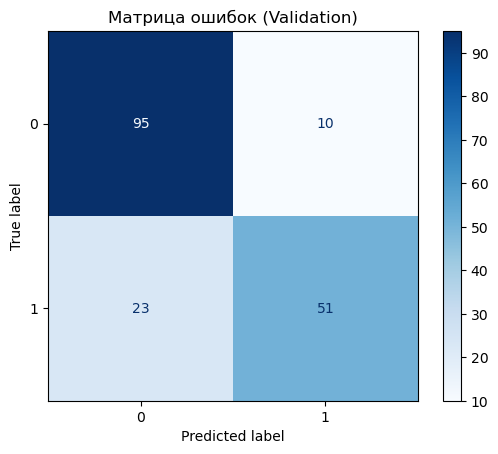

In [144]:
accuracy = accuracy_score(y_t_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy * 100:.2f}%")

# F1 score
f1 = f1_score(y_t_test, y_pred, average='weighted')
print(f"Ensemble Model F1 Score: {f1:.2f}")

# Матрица ошибок
cm = confusion_matrix(y_t_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Рисуем график
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Матрица ошибок (Validation)")
plt.show()




In [176]:
xgboost_model_t = XGBoost(
    base_tree=DecisionTree,  # Базовая модель — наше дерево решений
    n_trees=50,              # Количество деревьев
    learning_rate=0.1,       # Скорость обучения (вклад каждого дерева в итоговое предсказание)
    max_depth=5,             # Глубина деревьев
    forest_type='classification' # Режим работы: классификация 
)
xgboost_model_t.fit(X_t_train, y_t_train)



In [177]:
y_pred_xgb_t = xgboost_model_t.predict(X_t_test)

Ensemble Model Accuracy: 58.66%
Ensemble Model F1 Score: 0.43


<Figure size 800x600 with 0 Axes>

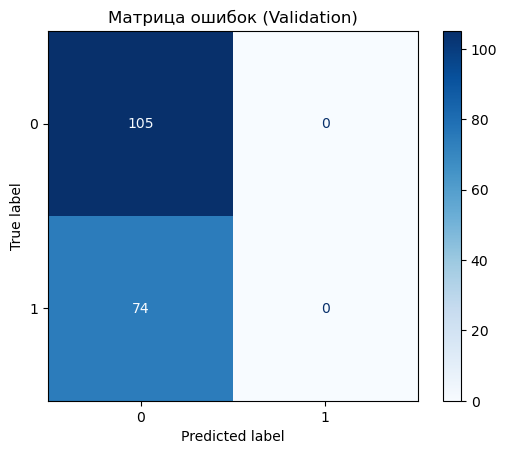

In [178]:
accuracy = accuracy_score(y_t_test, y_pred_xgb_t)
print(f"Ensemble Model Accuracy: {accuracy * 100:.2f}%")

# F1 score
f1 = f1_score(y_t_test, y_pred_xgb_t, average='weighted')
print(f"Ensemble Model F1 Score: {f1:.2f}")

# Матрица ошибок
cm = confusion_matrix(y_t_test, y_pred_xgb_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Рисуем график
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Матрица ошибок (Validation)")
plt.show()


In [191]:
# Функция для обучения и оценки модели с измерением времени
def evaluate_model_class(model, model_name, X_t_train, y_t_train, X_t_test, y_t_test):
    """Обучает модель, делает предсказания, оценивает метрики и измеряет время."""
    start_time = time.time()  # Засекаем время
    model.fit(X_t_train, y_t_train)  # Обучение
    elapsed_time = time.time() - start_time  # Измеряем время
    
    y_pred = model.predict(X_t_test)  # Предсказание

    # Вычисляем метрики
    accuracy = accuracy_score(y_t_test, y_pred)
    precision = precision_score(y_t_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_t_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_t_test, y_pred, average='weighted', zero_division=1)
    auc = roc_auc_score(y_t_test, y_pred)

    # Возвращаем результаты в виде словаря
    return {
        "Модель": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "Время (сек)": elapsed_time
    }

# Гиперпараметры (общие для всех)
param_grid = {
    "n_trees": [10, 50],  # Кол-во деревьев
    "max_depth": [3, 5],  # Глубина деревьев
}
base_tree = DecisionTree  
# Список моделей
models = [
    ("RandomForest (Custom)", RandomForest(base_tree=base_tree, n_trees=50, max_depth=5, forest_type="classification")),  
    ("XGBoost (Custom)", XGBoost(base_tree=base_tree, n_trees=50, max_depth=5, learning_rate=0.1, forest_type="classification")),
    ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("RandomForestClassifier", RandomForestClassifier(n_estimators=50, max_depth=5)),
    ("GradientBoostingClassifier", GradientBoostingClassifier(n_estimators=50, max_depth=5)),
]

# Храним результаты
results_t = []

# Прогоняем модели по всем параметрам
for model_name, model in models:
    for n_trees in param_grid["n_trees"]:
        for max_depth in param_grid["max_depth"]:
            # Настраиваем параметры для кастомных моделей
            if "Custom" in model_name:
                model.n_trees = n_trees
                model.max_depth = max_depth
            elif isinstance(model, (RandomForestClassifier, GradientBoostingClassifier)):
                model.set_params(n_estimators=n_trees, max_depth=max_depth)
            elif isinstance(model, DecisionTreeClassifier):
                model.set_params(max_depth=max_depth)

            # Оцениваем модель на тестовой выборке
            result = evaluate_model_class(model, f"{model_name} (trees={n_trees}, depth={max_depth})", 
                                          X_t_train, y_t_train, X_t_test, y_t_test)

            # Добавляем результаты к итоговому списку
            results_t.append(result)


In [194]:
# Преобразуем результаты в DataFrame
df_results_t = pd.DataFrame(results_t)

df_results_filtered_t = df_results_t[df_results_t["F1-Score"] > 0].sort_values(by="F1-Score", ascending=False)

# Отключаем перенос по ширине и увеличиваем лимит строк
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 100)

# Выводим таблицу
print(df_results_filtered_t)


                                            Модель  Accuracy  Precision    Recall  F1-Score       AUC  Время (сек)
13      RandomForestClassifier (trees=10, depth=5)  0.821229   0.824614  0.821229  0.817477  0.801737     0.012390
19  GradientBoostingClassifier (trees=50, depth=5)  0.815642   0.815622  0.815642  0.813462  0.800965     0.108159
15      RandomForestClassifier (trees=50, depth=5)  0.815642   0.816567  0.815642  0.812829  0.798970     0.055289
17  GradientBoostingClassifier (trees=10, depth=5)  0.810056   0.814654  0.810056  0.805268  0.788224     0.023480
12      RandomForestClassifier (trees=10, depth=3)  0.810056   0.814654  0.810056  0.805268  0.788224     0.012039
1        RandomForest (Custom) (trees=10, depth=5)  0.804469   0.804949  0.804469  0.801486  0.787452     1.160854
14      RandomForestClassifier (trees=50, depth=3)  0.804469   0.806144  0.804469  0.800754  0.785457     0.052269
2        RandomForest (Custom) (trees=50, depth=3)  0.804469   0.807724  0.80446

### Вывод: Аналогично регресси. Как и ожидалось ручные методы показали вполне приемлимую точность, но по времени обучения сильно проиграли "коробочным методам"